<a href="https://colab.research.google.com/github/konderal333/HGT-2022-EmDomArDon/blob/main/bert2bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load models and data

In [ ]:
!git clone https://github.com/konderal333/HGT-2022-EmDomArDon.git

Cloning into 'HGT-2022-EmDomArDon'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 163 (delta 5), reused 5 (delta 2), pack-reused 151
Receiving objects: 100% (163/163), 17.57 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
import numpy as np
import pandas as pd
import re

In [ ]:
df = pd.read_csv('/content/HGT-2022-EmDomArDon/cikkek_10k_cleanedv1.csv')

In [ ]:
print(df.isnull().values.any())
print(sum(df.duplicated()))

True
87


In [ ]:
df = df.dropna()
df = df.drop_duplicates()

In [ ]:
df = df.apply(lambda x: x.str.strip())
df['Textbody'] = df['Textbody'].apply(lambda x: re.sub(r"(\.)([A-Z])", r'\1 \2', str(x))) # add missing whitespace between sentences

df['Lead'] = df['Title'] + '. ' + df['Headline'] # maybe only headline and drop title?
df = df.drop(['Title', 'Headline'],axis=1)
df.head()

#reindexing the dataframe
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('SZTAKI-HLT/hubert-base-cc')

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/272k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# bert2bert
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5" -O model_bert2bert.tar.gz && rm -rf /tmp/cookies.txt

# model
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GEdOmmKZEJOD2Ei28FtVEf534-nBEcBd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GEdOmmKZEJOD2Ei28FtVEf534-nBEcBd" -O model.tar.gz && rm -rf /tmp/cookies.txt

--2022-11-30 11:51:45--  https://docs.google.com/uc?export=download&confirm=t&id=1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.101, 142.251.2.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/chgei24ef7v21jskr3o0sdtfeoaemold/1669809075000/03710960119062529382/*/1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5?e=download&uuid=73be69c8-8d62-4dcd-8889-715eba939324 [following]
--2022-11-30 11:51:45--  https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/chgei24ef7v21jskr3o0sdtfeoaemold/1669809075000/03710960119062529382/*/1jVivzwtgoZx38yMeZA5BthGGvoPxBZk5?e=download&uuid=73be69c8-8d62-4dcd-8889-715eba939324
Resolving doc-0o-18-docs.googleusercontent.com (doc-0o-18-docs.googleusercontent.com)... 142.251.2.132, 2607:

In [ ]:
import shutil
shutil.unpack_archive('model.tar.gz', 'model')
shutil.unpack_archive('model_bert2bert.tar.gz', 'bert2bert')

In [ ]:
import torch
from transformers import EncoderDecoderModel

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model_path = '/content/model/model/pytorch_model.bin'
config = '/content/model/model/config.json'
model = EncoderDecoderModel.from_pretrained(model_path, config=config).to(device)


# bert2bert_model_path = '/content/bert2bert/model/pytorch_model.bin'
# bert2bert_config = '/content/bert2bert/model/config.json'
# bert2bert = EncoderDecoderModel.from_pretrained(bert2bert_model_path, config=bert2bert_config).to(device)


Tutorial notebook:

https://colab.research.google.com/drive/1WIk2bxglElfZewOHboPFNj8H44_VAyKE?usp=sharing&fbclid=IwAR2-pdnudSutvgqIlUUg4NP1Q0wJO9NQbteg_wVL9n8gsS2yMTfMp9YfC6w#scrollTo=bYmdx-W1NAky

The majority of the codes found in that notebook is outdated, so we needed to make a couple of augmentations and changes in order to make them work in our environment.

##Functions to handle inputs larger than 512 tokens

In [ ]:
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<p>Method to reduce the length of sentences with more than 510 tokens:
<p>We get the first few whole sentences until we reach 255 tokens. (Let us assume that we get n tokens from these sentences, where n&#60;255). Then we get the last few whole sentences until these reach the remaining limit of tokens (510-n).
<p>So with this method we reduce the longer articles to texts which contain 510 tokens (or a bit less than 510), so that we get the beginning and the end of the article.

In [ ]:
def text_to_token_list(art_title, x):      
  token_list = []
  sen_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences
 
  for sen in nltk.tokenize.sent_tokenize(x):
    token_list.append(tokenizer.tokenize(sen))
    sen_list.append(sen)

  return token_list, sen_list

In [ ]:
dict_of_tokens = {} 
#this dict will contain the article title as keys and the tokenized lists from the function below as values for other purposes

def text_to_tokens(art_title, x):      
  #insert the text to tokenize; first breaks text into sentences, then makes a list of lists with the i-th element being the tokenization of the i-th sentence
  token_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences

  tokens, sentences = text_to_token_list(art_title, x)  #tokens and sentences

  new_text = ''      #this is the text which contains less than (or equal to) 510 tokens

  #total tokennumber
  len1 = 0
  for i in tokens:
    for j in i:
      len1 += 1

  #if the text is > 510 tokens, we will get the first few whole sentences (~255 tokens), and the last few whole sentences (~255 tokens)
  if len1 > 510:
    begin_sum = 0
    begin_tokens = []
    for index, elem1 in enumerate(tokens):
      if begin_sum + len(elem1) > 255:
        break
      else:
        begin_sum += len(elem1)
        begin_tokens.append(elem1)
        new_text = new_text + sentences[index] + " "   #appending the new text  

    end_indexes = []
    end_sum = 0
    end_tokens = []
    tokens.reverse()
    for index, elem2 in enumerate(tokens):
      if end_sum + len(elem2) > 510-begin_sum:
        break
      else:
        end_sum += len(elem2)
        end_tokens.append(elem2)
        end_indexes.append(-index-1)

    #finally reconstructing the text which has less than (or equal to) 510 tokens 
    end_indexes.reverse()
    for end_index in end_indexes:
      new_text = new_text + sentences[end_index] + " "


    end_tokens.reverse()
    final_tokens = []
    for elem3 in begin_tokens:
      final_tokens.append(elem3)
    for elem4 in end_tokens:
      final_tokens.append(elem4)

    dict_of_tokens[art_title] = final_tokens
    return new_text.strip()

  #if the text is < 510 tokens, we do not have to get the beginning and the end, we can use the whole text
  else:
    for sen in nltk.tokenize.sent_tokenize(x):
      new_text = new_text + sen + " "
      token_list.append(tokenizer.tokenize(sen))

    dict_of_tokens[art_title] = token_list
    return new_text.strip()

In [ ]:
# making the BERT tokenized sentences and the reduced sentences from each article

for i in range(len(df.Lead)):
  new_text = text_to_tokens(df.Lead[i].strip(), df.Textbody[i])
  df.at[i, 'Textbody'] = new_text

In [ ]:
import matplotlib.pyplot as plt
import statistics

number_of_tokens_all = []

for tokens in dict_of_tokens.values():
  length = 0
  for lists in tokens:
    length += len(lists)
  number_of_tokens_all.append(length)

In [ ]:
len(dict_of_tokens.keys())

9386

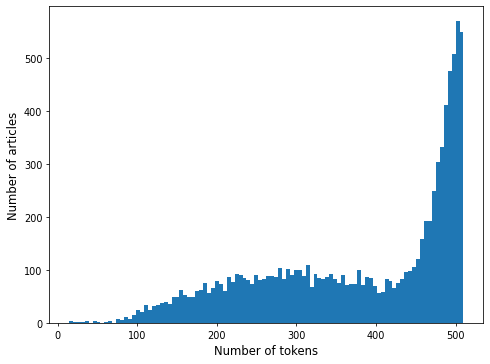

In [ ]:
plt.figure(figsize=(8,6), dpi=70)
plt.hist(number_of_tokens_all, bins=100, density=False)
#plt.title('Distribution of number of tokens generated from articles')
plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of articles', fontsize=12)
plt.show()

In [ ]:
# number of articles with tokens more that 510:
print(np.sum(np.asarray(number_of_tokens_all) > 510))

0


In [ ]:
# checking if the new texts really has the appropriate number of tokens
for index, row in df.iterrows():
  x = nltk.tokenize.sent_tokenize(row['Textbody'])
  all_len = 0
  for elem in x:
    all_len += len(tokenizer.tokenize(elem))
  if all_len > 510:
    print(index)

## Process data

In [ ]:
def process_data_to_model_inputs(batch):
        # Tokenize the input and target data
        inputs = tokenizer(batch['Textbody'], padding='max_length', truncation=True, max_length=512)
        outputs = tokenizer(batch['Lead'], padding='max_length', truncation=True, max_length=512)

        batch['input_ids'] = inputs.input_ids
        batch['attention_mask'] = inputs.attention_mask
        batch['decoder_input_ids'] = outputs.input_ids
        batch['decoder_attention_mask'] = outputs.attention_mask
        batch['labels'] = outputs.input_ids.copy()

        #batch['labels'] = [[-100 if token == tokenizer.pad_token_id else token for token in labels]
        #                    for labels in batch['labels']]
        batch['labels'] = [-100 if token == tokenizer.pad_token_id else token for token in batch['labels']]

        return batch

In [ ]:
#number of articles
df.shape[0]

9386

In [ ]:
# Full Data

# split is 70-15-15

train_data = df.iloc[0:int(np.floor(df.shape[0]*0.7))]
val_data = df.iloc[int(np.floor(df.shape[0]*0.7)):int(np.floor(df.shape[0]*0.85))]
test_data = df.iloc[int(np.floor(df.shape[0]*0.85)):]


#Partial Data
#train_data = df.iloc[0:20]
#val_data = df.iloc[20:30]
#test_data = df.iloc[30:40]

#train_data.reset_index(inplace=True)
#val_data.reset_index(inplace=True)
#test_data.reset_index(inplace=True)

#train_data = train_data.drop(['index'], axis=1)
#val_data = val_data.drop(['index'], axis=1)
#test_data = test_data.drop(['index'], axis=1)

In [ ]:
#Transforming the train and validation data
train_data = train_data.apply(process_data_to_model_inputs, axis=1)
train_data = train_data.drop(['Textbody', 'Lead'], axis=1)

val_data = val_data.apply(process_data_to_model_inputs, axis=1)
val_data = val_data.drop(['Textbody', 'Lead'], axis=1)

In [ ]:
train_data.head()

,input_ids,attention_mask,decoder_input_ids,decoder_attention_mask,labels
0,"[2, 2155, 7155, 2524, 4046, 4341, 15269, 14826...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 21086, 2018, 6480, 2045, 26204, 14350, 804...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 21086, 2018, 6480, 2045, 26204, 14350, 804..."
1,"[2, 30196, 9688, 11787, 11628, 2005, 11149, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 28589, 6997, 2039, 5833, 6505, 2094, 2005,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 28589, 6997, 2039, 5833, 6505, 2094, 2005,..."
2,"[2, 4405, 2546, 8984, 3576, 2079, 2005, 16667,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 5388, 28306, 7996, 2005, 16667, 3021, 2653...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 5388, 28306, 7996, 2005, 16667, 3021, 2653..."
3,"[2, 22158, 6688, 29536, 2005, 13549, 31735, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 12930, 12887, 6704, 7671, 2837, 20664, 297...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 12930, 12887, 6704, 7671, 2837, 20664, 297..."
4,"[2, 10708, 11447, 2685, 2066, 9763, 31736, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2930, 29814, 2066, 9763, 2033, 2718, 31741...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2930, 29814, 2066, 9763, 2033, 2718, 31741..."


In [ ]:
%%capture
!pip install datasets

In [ ]:
# converting to arrow dataset (easier to use)
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

train_data = Dataset(pa.Table.from_pandas(train_data))
val_data = Dataset(pa.Table.from_pandas(val_data))
test_data = Dataset(pa.Table.from_pandas(test_data))

# format type
train_data

Dataset({
    features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
    num_rows: 6570
})

In [ ]:
#converting the train and validation sets to tensors
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [ ]:
# example
train_data["labels"]

tensor([[    2, 21086,  2018,  ...,  -100,  -100,  -100],
        [    2, 28589,  6997,  ...,  -100,  -100,  -100],
        [    2,  5388, 28306,  ...,  -100,  -100,  -100],
        ...,
        [    2,  2155,  3165,  ...,  -100,  -100,  -100],
        [    2,  3512,  2664,  ...,  -100,  -100,  -100],
        [    2,  5753,  2336,  ...,  -100,  -100,  -100]])

## Prediction and evaluation before training

In [ ]:
# Metrics
!pip install rouge_score
import datasets
rouge = datasets.load_metric("rouge")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=04277f2b2326ee9c4d40caf40a289b2b013b2c5d99ae20d707d6e8f09ca1eb1a
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


In [ ]:
# Summary generation

def generate_summary(batch):
    # cut off at BERT max length 512
    inputs = tokenizer(batch['Textbody'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=142)

    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch['pred_summary'] = output_str

    return batch


In [ ]:
# Example article
batch = df.iloc[10]
batch['Textbody']

'Találkozni szeretett volna a Kölcsey Ferenc Gimnázium tanárait menesztő tankerületi vezetővel Soproni Tamás, terézvárosi polgármester. Marosi Betrix azonban nem látta indokoltnak, hogy beszélgessenek. A tankerületi vezető levelét Facebook-oldalán tette közzé a Momentum politikusa. Azt írja Marosi, hogy „természetesen a tankerületi központnak is az az érdeke, hogy az iskolában a helyzet normalizálódjon, a pedagógusok tanítsanak, a diákok tanuljanak”. A nevelés-oktatás feltételeinek biztosítása a VI. kerület állami fenntartású iskoláiban a tankerület feladata és felelőssége,„a tankerületi központ sem kíván beleszólni abba, hogy az Önkormányzat hogyan és kikkel látja el a feladatait.”A tankerületi vezető nem látja indokoltnak, hogy személyesen is találkozzon a kerület polgármesterével, mert a munkáltatói intézkedés „kizárólag a hatályos jogszabályokból fakadó lépés volt”. Marosi szerint az érintett pedagógusok a többszöri figyelmeztetés ellenére is visszatérően megszegték „a pedagógus jo

In [ ]:
# Now the summary
inputs = tokenizer(batch['Textbody'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
input_ids = inputs.input_ids.to(device)
attention_mask = inputs.attention_mask.to(device)
outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=50)
output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
output_str[0]

'Soproni Tamás szerint a tankerületi központnak is az az érdeke, hogy a tanárok és diákok tanuljanak.'

In [ ]:
# Original lead
df.iloc[10]['Lead']

'Lepattintotta a kölcseys tanárokat menesztő tankerületi vezető Soproni Tamást, aki beszélgetésre hívta. Nem akart találkozni a momentumos polgármesterrel, mert ő sem akar beleszólni abba, hogy az önkormányzat hogyan és kikkel látja el a feladatait.'

In [ ]:
# let's see the tokens
for t in input_ids:
    print(tokenizer.convert_ids_to_tokens(t))

['[CLS]', 'Találkoz', '##ni', 'szeretett', 'volna', 'a', 'Kölcs', '##ey', 'Ferenc', 'Gimnázium', 'tanára', '##it', 'men', '##esztő', 'tank', '##erületi', 'vezető', '##vel', 'Sopron', '##i', 'Tamás', ',', 'ter', '##éz', '##városi', 'polgármester', '.', 'Maros', '##i', 'Bet', '##rix', 'azonban', 'nem', 'látta', 'indokolt', '##nak', ',', 'hogy', 'beszélg', '##essenek', '.', 'A', 'tank', '##erületi', 'vezető', 'level', '##ét', 'Facebook', '-', 'oldalán', 'tette', 'közzé', 'a', 'Mo', '##ment', '##um', 'politikus', '##a', '.', 'Azt', 'írja', 'Maros', '##i', ',', 'hogy', '„', 'természetesen', 'a', 'tank', '##erületi', 'központ', '##nak', 'is', 'az', 'az', 'érdeke', ',', 'hogy', 'az', 'iskolában', 'a', 'helyzet', 'norm', '##alizál', '##ódjon', ',', 'a', 'pedagógusok', 'tanít', '##sanak', ',', 'a', 'diákok', 'tanul', '##janak', '”', '.', 'A', 'nevelés', '-', 'oktatás', 'feltételeinek', 'biztosítása', 'a', 'VI', '.', 'kerület', 'állami', 'fenntart', '##ású', 'iskol', '##áiban', 'a', 'tank', '##e

In [ ]:
# Now evaluate the whole test set
batch_size = 64

results = test_data.map(generate_summary, batched=True, batch_size=batch_size)
scores = rouge.compute(predictions=results["pred_summary"], references=results["Lead"], rouge_types=["rouge1", "rouge2", "rougeL"])
print(scores['rouge1'].mid)
print(scores['rouge2'].mid)
print(scores['rougeL'].mid)

  0%|          | 0/22 [00:00<?, ?ba/s]

Score(precision=0.38976875261589883, recall=0.20815894987520694, fmeasure=0.2604478706950102)
Score(precision=0.1415577158881446, recall=0.07404289087920049, fmeasure=0.09312708389638989)
Score(precision=0.2844265302335873, recall=0.14887726001138957, fmeasure=0.18741542643789832)


In [ ]:
# let's see a couple examples
print(results['Lead'][3])
print(results['pred_summary'][3])
print("")
print(results['Lead'][5])
print(results['pred_summary'][5])
print("")
print(results['Lead'][9])
print(results['pred_summary'][9])

Elon Musk visszaengedné Donald Trumpot a Twitterre. A milliárdos hibának tartja a 2021-ben hozott döntést a volt amerikai elnök végleges tiltásáról.
Elon Musk szerint hiba volt, hogy nem volt helyes letiltani Donald Trump volt amerikai elnök fiókját.

Messit látni és beleszeretni a Troyes-ba. A PSG hétvégi meccsén a hangulat közelebb volt a Fővárosi Nagycirkuszban tapasztaltakhoz, Messi és Neymar labdaérintésénél sikongatott a nézőtér, a hazai góloknál tűzijáték volt és hivatásos...
A Paris SG - Troyes francia bajnoki meccs után a Paris SG szurkolói a Parc des Princes stadionban ünnepelték a PSG - t.

Kína járványkezelési stratégiája fenntarthatatlan, ráadásul emberjogi és gazdasági szempontból is aggályos a WHO szerint. A „dinamikus zéró-Covid” miatt van több mint egy hónapja vesztegzár alatt a 25 milliós Sanghaj.
A WHO szerint a kínai járványkezelés fenntartása fenntarthatatlan.


As we can see, the sentences are mostly correct grammatically, but their meaning leaves a lot to be desired.

## Train further

In [ ]:
# Metrics
!pip install rouge_score
import datasets
rouge = datasets.load_metric("rouge")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=4111e5a6d11746e5bd07838874780ce0ab56fb40c10050e1cc595fc719255994
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


In [ ]:
#next step: ezeket állítani
model.config.max_length = 128
model.config.min_length = 56
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 3

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

batch_size = 20

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True, 
    output_dir="./output",
    generation_max_length=128,
    logging_steps=16,
    save_steps=48,
    eval_steps=16,
    gradient_accumulation_steps=1, 
    eval_accumulation_steps=None, 
    eval_delay=0, 
    learning_rate=5e-07, 
    weight_decay=0.01,
    load_best_model_at_end=True
)




In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid

    return {
        "rouge1_precision": round(rouge_output.precision, 4),
        "rouge1_recall": round(rouge_output.recall, 4),
        "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6570
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 987
  Number of trainable parameters = 249636609
/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained 

Step,Training Loss,Validation Loss,Rouge1 Precision,Rouge1 Recall,Rouge1 Fmeasure
16,10.249100,10.513105,0.266900,0.365700,0.300900
32,9.633800,9.919925,0.265100,0.363900,0.298900
48,9.225800,9.513309,0.263800,0.361500,0.297100
64,8.952900,9.180478,0.261600,0.357700,0.294200
80,8.546300,8.849298,0.259700,0.351100,0.290600
96,8.340700,8.546598,0.254700,0.342700,0.284100
112,7.926500,8.252094,0.254300,0.336000,0.281200
128,7.665100,7.977861,0.250100,0.326200,0.274900
144,7.472300,7.692203,0.249600,0.313000,0.269000
160,7.235100,7.416022,0.246400,0.298600,0.261100


***** Running Evaluation *****
  Num examples = 1408
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1408
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1408
  Batch size = 20
Saving model checkpoint to ./output/checkpoint-48
Configuration saved in ./output/checkpoint-48/config.json
Model weights saved in ./output/checkpoint-48/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
***** Running Evaluation *****
  Num examples = 1408
  Batch size = 20
*

TrainOutput(global_step=987, training_loss=4.359344217673382, metrics={'train_runtime': 12168.5399, 'train_samples_per_second': 1.62, 'train_steps_per_second': 0.081, 'total_flos': 1.209126987260928e+16, 'train_loss': 4.359344217673382, 'epoch': 3.0})

In [ ]:
# load the partially trained model
model = EncoderDecoderModel.from_pretrained("/content/output/checkpoint-960").to(device)

loading configuration file /content/output/checkpoint-960/config.json
Model config EncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "/content/model/model/pytorch_model.bin",
  "architectures": [
    "EncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "SZTAKI-HLT/hubert-base-cc",
    "add_cross_attention": true,
    "architectures": null,
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hid

## Evaluation after further training

In [ ]:
batch_size = 64

results = train_data.map(generate_summary, batched=True, batch_size=batch_size)
scores = rouge.compute(predictions=results["pred_summary"], references=results["Lead"], rouge_types=["rouge1", "rouge2", "rougeL"])
print(scores['rouge1'].mid)
print(scores['rouge2'].mid)
print(scores['rougeL'].mid)

  0%|          | 0/103 [00:00<?, ?ba/s]

Score(precision=0.09217217719543683, recall=0.2221110438622893, fmeasure=0.12225751722685252)
Score(precision=0.012733886272677845, recall=0.030615734169001374, fmeasure=0.016857069567596215)
Score(precision=0.06169218603839187, recall=0.1488573749493489, fmeasure=0.08161695000590571)


In [ ]:
# save to csv
results_df = pd.DataFrame({})
results_df['Lead'] = results['Lead']
results_df['pred_summary'] = results['pred_summary']
results_df['Textbody'] = results['Textbody']
results_df.to_excel('results_df.xlsx', index=False)